In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [24]:
class Database(object):
    def __init__(self, size=100, data=None):
        if data is None:
            self.n = size
            self.data = np.random.randint(0,2,size=size,dtype='bool')
        else:
            self.n = len(data)
            self.data = data

    def get_adjacent(self):
        adj_data = self.data.copy()
        idx = np.random.randint(0, self.n)
        adj_data[idx] = 1 - adj_data[idx]
        return Database(data = adj_data)

def coin_fair(size):
    return np.random.randint(0,2,size=size)

def coin_biased(eps, data):
    size = len(data)
    prob = [
        np.exp(eps) / (1 + np.exp(eps)),
        1 / (1 + np.exp(eps))
           ]
    flip = np.random.choice([0,1],size,p=prob)
    return np.bitwise_xor(data, flip) # not ~ xor with 1

def randomized_response(db, q, eps):
    randomized = coin_biased(eps, db.data)
    db_r = Database(data=randomized)
    response = q(db_r)
    return response

def almost_random(db, q):
    ct_if = coin_fair(db.n)
    ct_val = coin_fair(db.n)
    data = db.data.copy()
    data[ct_if == 0] = ct_val[ct_if == 0]
    db_p = Database(data=data)
    return q(db_p)

def privacy_loss(db1, db2, q_dp, r, n_observ=100):
    """approximating privacy loss using repeated experiments"""
    r_dp1 = [] 
    r_dp2 = []
    
    for i in range(n_observ):
        r_dp1.append(q_dp(db1))
        r_dp2.append(q_dp(db2))

    P1 = (np.r_[r_dp1] == r).mean() + 1e-7 # doing it to avoid 0s under log
    P2 = (np.r_[r_dp2] == r).mean() + 1e-7 # and division by zero
    return np.abs(np.log(P1 / P2)), P1, P2

In [3]:
db = Database(10000)
db_a = db.get_adjacent()

In [19]:
q = lambda db: np.mean(db.data) #(db.data == 1).mean()
q_ar = lambda db: almost_random(db, q)

In [20]:
r = q(db)

In [21]:
privacy_losses_ar = [privacy_loss(db, db_a, q_ar, r, n_observ=1000) for i in tqdm(range(100))]

HBox(children=(IntProgress(value=0), HTML(value='')))

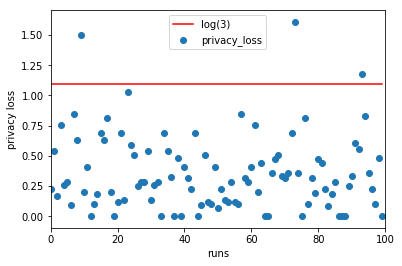

In [22]:
plt.scatter(range(100),[x[0] for x in privacy_losses_ar], label='privacy_loss')
plt.plot(range(100),[np.log(3)]*100,c='r', label='log(3)')
plt.xlim(0,100)
plt.xlabel('runs')
plt.ylabel('privacy loss')
plt.legend()

In [23]:
q_rr3 = lambda db: randomized_response(db, q, 3)
q_rr5 = lambda db: randomized_response(db, q, 5)

In [25]:
privacy_losses_rr3 = [ privacy_loss(db, db_a, q_rr3, r, n_observ=1000) for i in tqdm(range(100)) ]
privacy_losses_rr5 = [ privacy_loss(db, db_a, q_rr5, r, n_observ=1000) for i in tqdm(range(100)) ]

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

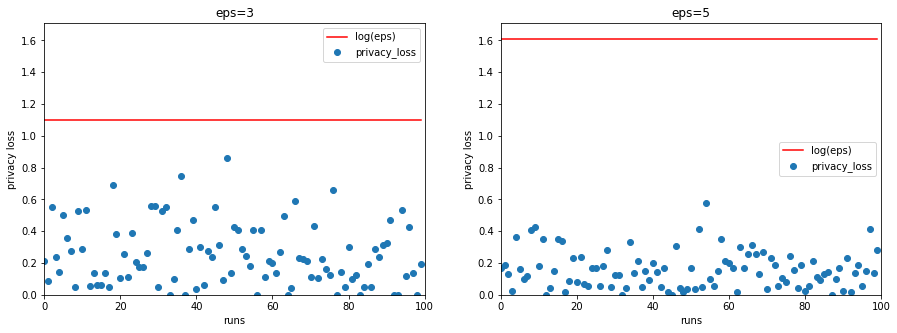

In [28]:
f,ax = plt.subplots(1,2, figsize=(15, 5))
for a,l,eps in zip(ax,[privacy_losses_rr3, privacy_losses_rr5], [3, 5]):
    a.scatter(range(100), [x[0] for x in l], label='privacy_loss')
    a.plot(range(100), [np.log(eps)]*100, c='r', label='log(eps)')
    a.set_xlim(0,100)
    a.set_ylim(0,np.log(5)+0.1)
    a.set_xlabel('runs')
    a.set_ylabel('privacy loss')
    a.legend()
    a.set_title(f'eps={eps}')

In [29]:
def RR_alpha(beta, eps, n):
    return (1 + np.exp(eps)) / (np.exp(eps) - 1) * np.sqrt( np.log(2/beta) / (2*n) )

def measure_diff(rr, r, eps):
    return np.abs(
        (1 + np.exp(eps)) / (np.exp(eps) - 1) *\
        (rr - 1/(1+np.exp(eps))) - r)

In [34]:
r = q(db)
rr = [ q_rr3(db) for i in tqdm(range(1000)) ]

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

In [35]:
diff = [measure_diff(x, r, 3) for x in rr]

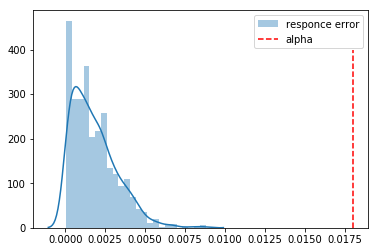

In [36]:
sns.distplot(diff, label='responce error')
plt.vlines([RR_alpha(0.01, 3, db.n)], 0, 400, colors='r', linestyles='--', label='alpha')
plt.legend()